# ResNet CIFAR-10

TensorFlow implementation of Residual neural network for CIFAR-10 based on the [original paper](https://doi.org/10.48550/arXiv.1512.03385).


In [2]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras import activations, callbacks, datasets, layers, regularizers

### Utility functions


Function for plotting Loss and Accuracy of training.


In [3]:
def plot_results(hist):
    fig, axes = plt.subplots(1, 2, figsize=(25, 8))
    axes[0].plot(hist.history["loss"], label="loss")
    axes[0].plot(hist.history["val_loss"], label="val_loss")
    axes[1].plot(hist.history["accuracy"], label="accuracy")
    axes[1].plot(hist.history["val_accuracy"], label="val_accuracy")

    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(True)

### Model definition


Baseline Residual layer


In [4]:
BaseConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    kernel_initializer="he_normal",
    kernel_regularizer=regularizers.l2(0.001),
    use_bias=False,
)


class ResidualLayer(layers.Layer):
    def __init__(self, filters, strides=(1, 1), activation="relu", **kwargs):
        super().__init__(**kwargs)

        # variables for get_config
        self.filters = filters
        self.strides = strides
        self.activation = activations.get(activation)

        # variables for the building block
        self.conv0 = BaseConv2D(filters, strides=strides)
        self.bn0 = layers.BatchNormalization()
        self.conv1 = BaseConv2D(filters)
        self.bn1 = layers.BatchNormalization()

        # variables for projection
        self.conv_reduce = BaseConv2D(filters, kernel_size=(1, 1), strides=strides)
        self.bn_reduce = layers.BatchNormalization()

    def build(self):
        pass

    def call(self, inputs):
        X = self.conv0(inputs)
        X = self.bn0(X)
        X = self.activation(X)
        X = self.conv1(X)
        X = self.bn1(X)

        skip_X = inputs
        if self.strides[0] > 1:  # change dimensionality when they don't match
            skip_X = self.conv_reduce(skip_X)
            skip_X = self.bn_reduce(skip_X)

        return self.activation(X + skip_X)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "filters": self.filters,
                "strides": self.strides,
                "activation": self.activation,
            }
        )
        return config

Generator function

Based on input n, the function will create a model with $6n + 2$ layers.


In [5]:
def resnet(n):
    print(f"Generating ResNet-{6 * n + 2}")

    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(32, 32, 3)),
            BaseConv2D(16),
            layers.BatchNormalization(),
            layers.ReLU(),
        ]
    )

    for filters in [16, 32, 64]:
        for layer in range(n):
            if filters > 16 and layer == 0:
                model.add(ResidualLayer(filters, strides=(2, 2)))
            else:
                model.add(ResidualLayer(filters))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(10, activation="softmax"))

    return model

### Data preparation


In [6]:
classes = (
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

Data augmentation


In [8]:
padded = layers.ZeroPadding2D(padding=4)(train_images)
flipped = layers.RandomFlip(mode="horizontal")(padded, training=True)
train_images = layers.RandomCrop(32, 32)(flipped, training=True)

In [9]:
train_images, test_images = train_images / 255.0, test_images / 255.0

val_images = train_images[-5000:]
val_labels = train_labels[-5000:]
train_images = train_images[:-5000]
train_labels = train_labels[:-5000]

### Training


$n=9$, 56 layers ResNet


In [10]:
model = resnet(9)
model.summary()

Generating ResNet-56


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer (ResidualLayer)  │ (None, 32, 32, 16)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer_1                │ (None, 32, 32, 16)     │         4,736 │
│ (ResidualLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer_2                │ (None, 32, 32, 16)     │         4,736 │
│ (ResidualLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer_3                │ (None, 32, 32, 16)     │         4,736 │
│ (ResidualLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer_4                │ (None, 32, 32, 16)     │         4,736 │
│ (ResidualLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer_5                │ (None, 32, 32, 16)     │         4,736 │
│ (ResidualLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer_6                │ (None, 32, 32, 16)     │         4,736 │
│ (ResidualLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer_7                │ (None, 32, 32, 16)     │         4,736 │
│ (ResidualLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer_8                │ (None, 32, 32, 16)     │         4,736 │
│ (ResidualLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer_9                │ (None, 16, 16, 32)     │        14,720 │
│ (ResidualLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer_10               │ (None, 16, 16, 32)     │        18,688 │
│ (ResidualLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer_11               │ (None, 16, 16, 32)     │        18,688 │
│ (ResidualLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer_12               │ (None, 16, 16, 32)     │        18,688 │
│ (ResidualLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer_13               │ (None, 16, 16, 32)     │        18,688 │
│ (ResidualLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_layer_14               │ (None, 16, 16, 32)     │        18,68

 Total params: 860,026 (3.28 MB)

 Trainable params: 855,770 (3.26 MB)

 Non-trainable params: 4,256 (16.62 KB)

In [11]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

n_epochs = 100

es_cb = callbacks.EarlyStopping(
    monitor="val_accuracy", patience=16, restore_best_weights=True
)
reduce_lr_cb = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4)

history = model.fit(
    train_images,
    train_labels,
    batch_size=128,
    epochs=n_epochs,
    callbacks=[es_cb, reduce_lr_cb],
    validation_data=(val_images, val_labels),
)

Epoch 1/100


I0000 00:00:1713038718.408576    9682 service.cc:145] XLA service 0x7f8b840021e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713038718.408621    9682 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-04-13 22:05:18.879761: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-13 22:05:20.270226: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  2/352 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.0879 - loss: 10.1202  

I0000 00:00:1713038729.738848    9682 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


352/352 ━━━━━━━━━━━━━━━━━━━━ 52s 86ms/step - accuracy: 0.1313 - loss: 6.8682 - val_accuracy: 0.0976 - val_loss: 4.3778 - learning_rate: 0.1000
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.3733 - loss: 2.7445 - val_accuracy: 0.1810 - val_loss: 3.9099 - learning_rate: 0.1000
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.5548 - loss: 1.6429 - val_accuracy: 0.4316 - val_loss: 2.1951 - learning_rate: 0.1000
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.6600 - loss: 1.2859 - val_accuracy: 0.5282 - val_loss: 1.6916 - learning_rate: 0.1000
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.7080 - loss: 1.1568 - val_accuracy: 0.3200 - val_loss: 2.8542 - learning_rate: 0.1000
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.7260 - loss: 1.1226 - val_accuracy: 0.5004 - val_loss: 1.8411 - learning_rate: 0.1000
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7466 - loss: 

              precision    recall  f1-score   support

    airplane       0.86      0.84      0.85      1032
  automobile       0.91      0.96      0.93       943
        bird       0.81      0.76      0.78      1067
         cat       0.71      0.73      0.72       972
        deer       0.82      0.85      0.83       963
         dog       0.78      0.82      0.80       956
        frog       0.90      0.84      0.87      1070
       horse       0.86      0.92      0.89       937
        ship       0.93      0.90      0.92      1033
       truck       0.92      0.90      0.91      1027

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



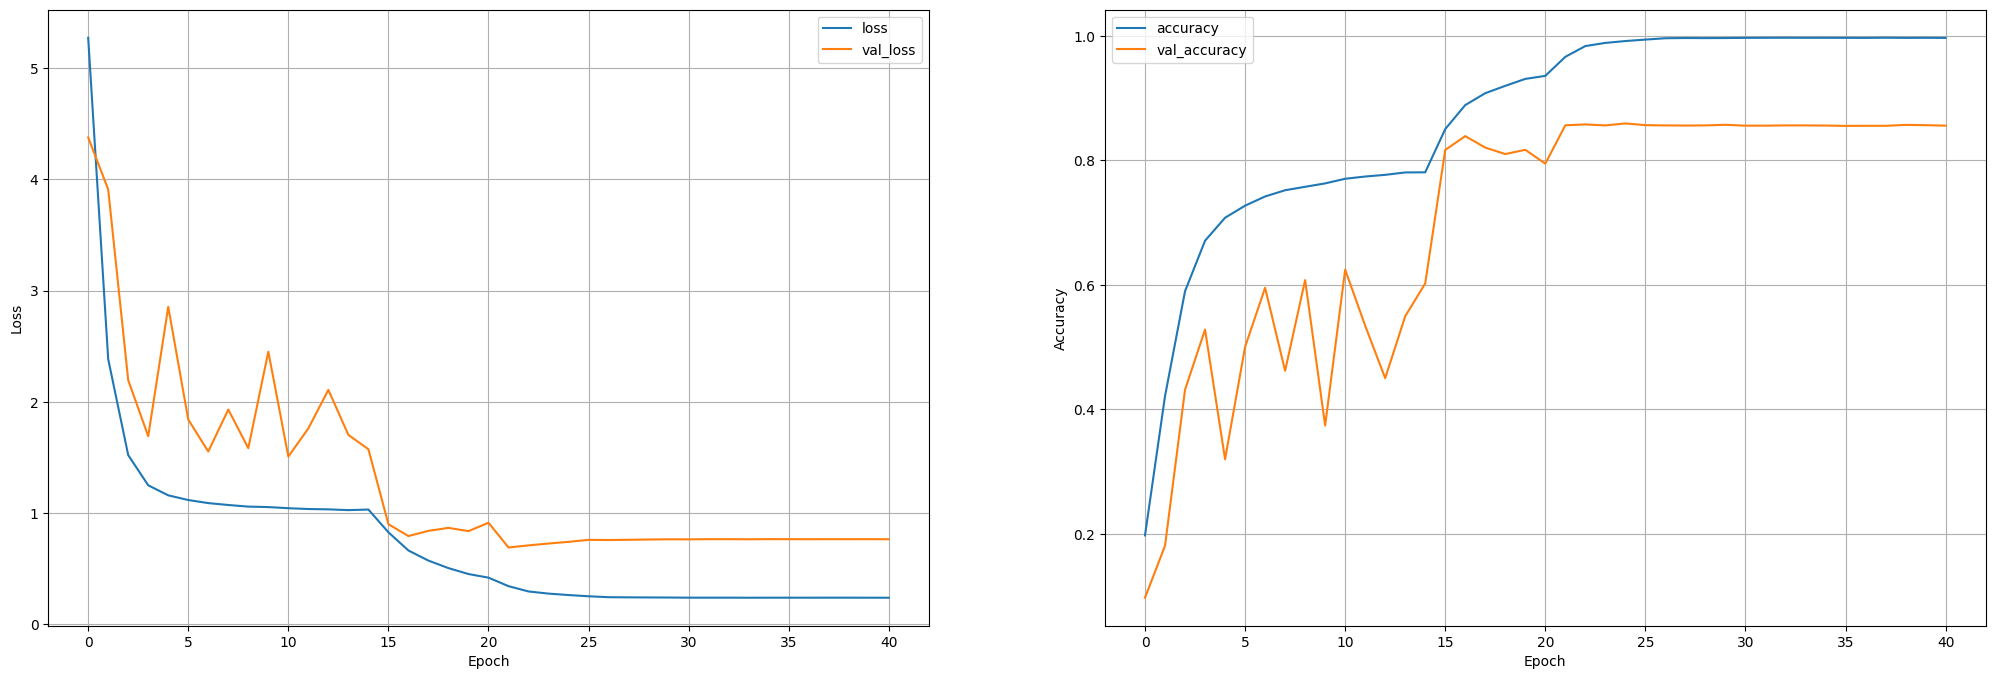

In [12]:
plot_results(history)

predicted_labels = np.argmax(model.predict(test_images, verbose=0), axis=1)
cr = classification_report(predicted_labels, test_labels, target_names=classes)
print(cr)

A bit overfit :)